##Forecasting flights using Time Series Analysis with Covid data as Regressors

In [0]:
# load fbprophet library
dbutils.library.installPyPI('FBProphet', version='0.5') 
dbutils.library.installPyPI('holidays', version='0.9.12') 
dbutils.library.installPyPI('mlflow')
dbutils.library.restartPython()

In [0]:
import mlflow
import mlflow.sklearn
import shutil

from pyspark.sql.types import *
from pyspark.sql.functions import pandas_udf, PandasUDFType

import pandas as pd

import logging
logging.getLogger('py4j').setLevel(logging.ERROR)

from fbprophet import Prophet

# note: the error "Importing plotly failed" is expected because of prophet limitations

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.

In [0]:
# structure of the dataset returned by the function
result_schema =StructType([
  StructField('geoId',StringType()),
  StructField('ds',TimestampType()),
  StructField('y', FloatType()),
  StructField('yhat', FloatType()),
  StructField('yhat_lower', FloatType()),
  StructField('yhat_upper', FloatType()),
  StructField('trend',FloatType()),
  StructField('trend_lower', FloatType()),
  StructField('trend_upper', FloatType())
  ])

# forecast function
@pandas_udf( result_schema, PandasUDFType.GROUPED_MAP )
def get_forecast(keys, group_pd):
  
  # DATA PREPARATION
  # identify geoId and time to forecast
  geoId = keys[0]
  time_to_forecast=keys[1]
  
  # extract valid historical data
  history_pd = group_pd[group_pd['is_historical']==1].dropna()  
  
  # ---------------------------------  
  
  # TRAIN MODEL
    
  # configure model
  history_pd["cap"] = 100000
  history_pd["floor"] = 0
  model = Prophet(
    growth='linear',
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=False,
    interval_width=0.80)
  
  # identify the regressors
  model.add_regressor('cases_weekly')
  model.add_regressor('deaths_weekly')

  # train model
  model.fit( history_pd )

  # save models for potential later use
  model_path = '/mnt/BD-project/timeseries_regressors/{0}'.format(geoId)
  shutil.rmtree(model_path, ignore_errors=True)
  mlflow.sklearn.save_model( model, model_path)
  # ---------------------------------
  
  # FORECAST
   
  # assemble regressors
  
  future_pd = group_pd[group_pd['is_historical']==0]
  future_pd = future_pd[['ds', 'cases_weekly', 'deaths_weekly']]
  
  # generate forecast
  future_pd["floor"]=0
  future_pd["cap"]=100000
  forecast_pd = model.predict(future_pd)
  # ---------------------------------
  
  # PREPARE RESULTS
  
  # merge forecast with history
  results_pd = forecast_pd.merge(
    history_pd[['ds','y']], 
    how='left', 
    on='ds',
    sort=True,
    suffixes=('_l','_r')
   )
 
  # assign geoId to results
  results_pd['geoId']=geoId
  # ---------------------------------
  
  return results_pd[
      ['geoId', 'ds', 
       'y', 'yhat', 'yhat_lower', 'yhat_upper',
       'trend', 'trend_lower', 'trend_upper']
        ]

In [0]:
from pyspark.sql.types import *
from pyspark.sql.functions import to_timestamp, col


# read into the DELTA LAKE
covid_flights = spark.read.format("delta").load("/mnt/BD-project/delta/covid_flights")
covid_flights = covid_flights.withColumn('date', to_timestamp(col("dateRep"), 'dd/MM/yyyy'))

# make the dataframe queriable as a temporary view
covid_flights.createOrReplaceTempView('covid_flights')

In [0]:
from datetime import timedelta
from pyspark.sql.functions import col, when

# define number of weeks to forecast
weeks_to_forecast = 5

# assemble historical dataset for training
sql_statement = '''
  SELECT
    geoId,
    CAST(date as date) as ds,
    flights as y,
    cases_weekly,
    deaths_weekly
  FROM covid_flights
  ORDER BY geoId, ds
  '''

flights_history = (
  spark
    .sql( sql_statement )
    .repartition(sc.defaultParallelism, ['geoId'])
  ).cache()



# fill data pre-covid
flights_history = flights_history.na.fill(value=0,subset=["cases_weekly", "deaths_weekly"])

# delete incomplete data
flights_history = flights_history.dropna()
counts=flights_history.groupBy("geoId").count()
max_count = counts.agg({"count": "max"}).collect()[0][0]
flights_history = flights_history.join(counts, "geoId")
flights_history = flights_history.where(col("count")==max_count).drop("count")



# define forecasting time
max_time = flights_history.agg({"ds": "max"}).collect()[0][0]
max_historical = max_time - timedelta(weeks=weeks_to_forecast)
max_historical

flights_history = flights_history.withColumn("is_historical", when(col("ds") <= max_historical,1).otherwise(0) )

flights_history =  flights_history.withColumn("ds", flights_history.ds.cast("timestamp"))



In [0]:
from pyspark.sql.functions import lit

# generate forecast
forecast = (
   flights_history
    .groupBy('geoId', lit(weeks_to_forecast))
    .apply(get_forecast)
  )
forecast.createOrReplaceTempView('forecast_timeseries_with_regressors')

/databricks/spark/python/pyspark/sql/pandas/group_ops.py:76: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
 "more details.", UserWarning)

In [0]:
#uncomment the following to visualize the resulted table
#display(forecast)

geoId ds y yhat yhat_lower yhat_upper trend trend_lower trend_upper AT 2020-12-07T00:00:00.000+0000 null -1031.1934 -1734.2352 -332.15662 611.91455 611.9145 611.9146 AT 2020-12-14T00:00:00.000+0000 null -711.64105 -1450.9828 11.046229 593.51636 593.5162 593.5165 AT 2020-12-21T00:00:00.000+0000 null -1195.1366 -1884.9629 -508.16135 575.1181 575.1178 575.11847 AT 2020-12-28T00:00:00.000+0000 null -810.22955 -1555.864 -148.06488 556.7199 556.71936 556.72046 AT 2021-01-04T00:00:00.000+0000 null -140.73503 -947.53357 547.60657 538.3217 538.3209 538.3225 AU 2020-12-07T00:00:00.000+0000 null 3559.5466 583.4816 6516.981 3209.522 3209.52 3209.5244 AU 2020-12-14T00:00:00.000+0000 null 3451.7996 866.6621 6469.133 3090.7722 3090.7642 3090.7817 AU 2020-12-21T00:00:00.000+0000 null 3294.5522 308.8263 6071.6465 2972.0225 2972.0066 2972.0417 AU 2020-12-28T00:00:00.000+0000 null 3196.004 154.83524 5981.6553 2853.2727 2853.2458 2853.3025 AU 2021-01-04T00:00:00.000+0000 null 3038.8079 158.23033 5825.1387 2734.523 2734.4812 2734.5647 EE 2020-12-07T00:00:00.000+0000 null 94.6234 30.258596 158.83995 88.41669 88.41668 88.41669 EE 2020-12-14T00:00:00.000+0000 null 113.23733 53.217674 172.2918 86.368 86.36797 86.36801 EE 2020-12-21T00:00:00.000+0000 null 82.63307 21.019297 146.53812 84.319305 84.31927 84.31934 EE 2020-12-28T00:00:00.000+0000 null -47.364937 -110.42706 16.799276 82.270615 82.27056 82.270676 EE 2021-01-04T00:00:00.000+0000 null -59.274227 -114.142365 6.202572 80.221924 80.22184 80.22201 FR 2020-12-07T00:00:00.000+0000 null 1555.1824 -253.83302 3407.911 3006.3972 3006.3972 3006.3975 FR 2020-12-14T00:00:00.000+0000 null 1693.8666 -241.188 3691.57 2954.537 2954.5366 2954.5376 FR 2020-12-21T00:00:00.000+0000 null 1897.2986 125.0679 3726.151 2902.677 2902.676 2902.678 FR 2020-12-28T00:00:00.000+0000 null 1843.8237 -113.93554 3726.0776 2850.817 2850.8154 2850.8186 FR 2021-01-04T00:00:00.000+0000 null 2474.3457 712.8822 4387.716 2798.9568 2798.9546 2798.959 IL 2020-12-07T00:00:00.000+0000 null 26.890587 -222.92604 240.55026 34.31556 34.315533 34.31558 IL 2020-12-14T00:00:00.000+0000 null 36.835754 -200.80005 280.25446 23.593607 23.593502 23.593704 IL 2020-12-21T00:00:00.000+0000 null 37.284534 -202.06921 269.7014 12.871656 12.871436 12.871861 IL 2020-12-28T00:00:00.000+0000 null 48.72072 -175.89691 287.012 2.149706 2.1493418 2.150037 IL 2021-01-04T00:00:00.000+0000 null 72.776245 -179.2525 324.45734 -8.572245 -8.572791 -8.571748 LT 2020-12-07T00:00:00.000+0000 null 54.173664 -15.662565 121.98139 363.32394 363.32394 363.32394 LT 2020-12-14T00:00:00.000+0000 null -71.09869 -134.82622 1.0591828 371.76535 371.76535 371.76535 LT 2020-12-21T00:00:00.000+0000 null -114.78297 -181.99222 -45.00484 380.20676 380.20676 380.2068 LT 2020-12-28T00:00:00.000+0000 null -127.06814 -197.52568 -56.989872 388.64816 388.64813 388.6482 LT 2021-01-04T00:00:00.000+0000 null -958.76263 -1025.5869 -890.40686 397.08957 397.0895 397.0896 MY 2020-12-07T00:00:00.000+0000 null 543.7657 -66.84745 1123.32 -367.6441 -367.6443 -367.64383 MY 2020-12-14T00:00:00.000+0000 null 775.7209 141.3171 1356.0216 -415.2768 -415.27786 -415.2758 MY 2020-12-21T00:00:00.000+0000 null 975.7851 392.61414 1568.8197 -462.9095 -462.9117 -462.90717 MY 2020-12-28T00:00:00.000+0000 null 1709.6414 1147.0582 2320.9631 -510.54218 -510.5458 -510.53857 MY 2021-01-04T00:00:00.000+0000 null 1142.4437 542.19006 1714.7095 -558.17487 -558.18005 -558.1695 NZ 2020-12-07T00:00:00.000+0000 null 1571.2687 744.5702 2380.7637 1416.9993 1416.999 1416.9995 NZ 2020-12-14T00:00:00.000+0000 null 1574.3916 755.87714 2376.7266 1409.0284 1409.0273 1409.0294 NZ 2020-12-21T00:00:00.000+0000 null 1551.629 790.4324 2270.067 1401.0575 1401.0553 1401.0597 NZ 2020-12-28T00:00:00.000+0000 null 1547.3561 744.2478 2261.613 1393.0867 1393.083 1393.0903 NZ 2021-01-04T00:00:00.000+0000 null 855.2658 62.368317 1557.5487 1385.1157 1385.1105 1385.1208 CA 2020-12-07T00:00:00.000+0000 null 3171.4749 1708.6316 4625.9844 1502.7715 1502.7714 1502

In [0]:
%sql
-- create forecast table
create or replace table forecast_with_regressors (
  geoId string,
  ds timestamp,
  y float,
  yhat float,
  yhat_lower float,
  yhat_upper float,
  trend float,
  trend_lower float,
  trend_upper float
  )
using delta
partitioned by (geoId);

-- load data to it
insert into forecast_with_regressors
select 
  geoId,
  ds,
  y,
  yhat,
  yhat_upper,
  yhat_lower,
  trend,
  trend_lower,
  trend_upper
  
from forecast_timeseries_with_regressors;

#### Results

By default we present the data for the United States, but any computed Country can be queried

In [0]:
# extract the forecast from our persisted dataset
forecast_pd = (
  spark
    .table('forecast_with_regressors')
    .filter('geoId="US"')
    ).toPandas()

In [0]:
# retrieve the model for this country 
model = mlflow.sklearn.load_model('/mnt/BD-project/timeseries_regressors/US')

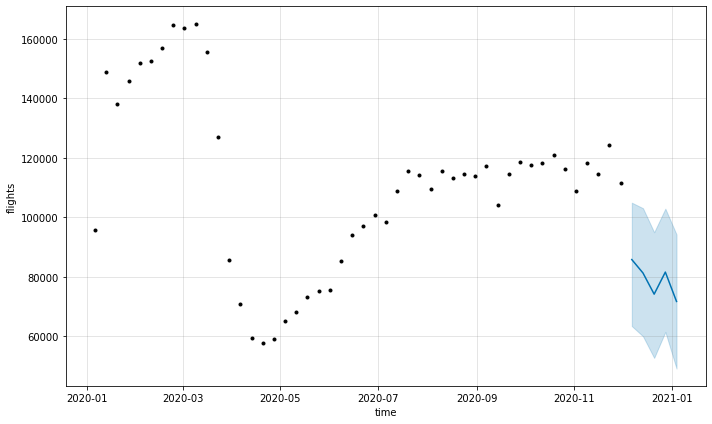

In [0]:
# construct a visualization of the forecast
predict_fig = model.plot(forecast_pd, xlabel='time', ylabel='flights')


# display the chart
display(predict_fig)

In [0]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import pandas as pd

# calulate evaluation metrics
evaluation = spark.createDataFrame(forecast_pd)
evaluation = evaluation["geoId", "ds", "yhat"].join(flights_history["geoId", "ds", "y"], ["geoId", "ds" ])
result_pd = evaluation.select("*").toPandas()
actuals = result_pd['y']
predicted = result_pd['yhat']
mae = mean_absolute_error( actuals, predicted )
mse = mean_squared_error( actuals, predicted )
rmse = sqrt( mse )
  
# assemble result
print( '\n'.join(['MAE: {0}', 'MSE: {1}', 'RMSE: {2}']).format(mae, mse, rmse) )

MAE: 27707.3796875
MSE: 927875620.2835083
RMSE: 30461.050872934575